## Topic modeling of Positive and Negative reviews of businesses

In [1]:
pip install gensim # Library for unsupervised topic modeling

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install pyLDAvis # Library for topics interpretation

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
import nltk # Natural Language toolkit for text processing
import re # Regular expression library for text cleaning and information extraction based on patterns
from nltk.corpus import stopwords # Remove words which do not add much meaning to a sentence 
from nltk.stem.porter import PorterStemmer # Reducing words to their root form eg make them singular 
from nltk.stem import WordNetLemmatizer # Reducing words to their root form eg past tense to present tense
from sklearn.feature_extraction.text import CountVectorizer # Vectorization of words
from sklearn.model_selection import train_test_split # Split for training and testing the model
from sklearn.naive_bayes import MultinomialNB
import joblib
import gensim
from gensim import corpora
from gensim.models.coherencemodel import CoherenceModel # To measure the interpretability of topics
import matplotlib.pyplot as plt # Library to produce charts
import pyLDAvis

In [4]:
# Import the results of textblob with sentiment scoring results
data1 = pd.read_csv(r'/Users/vatsalgarg/Downloads/InsightsHub/result_textblob.csv', encoding="unicode_escape")
data2 =data1[['Review','Feedback_text','Sentiment_Pred_tb','Date']]
data2.head()

,Review,Feedback_text,Sentiment_Pred_tb,Date
0,0.174444,"Burger Co, in a word, rocks. I read some of th...",Positive,21-Aug
1,0.375000,Spicy burger is amazing. Huge burgers cooked t...,Positive,21-Jul
2,0.000000,I appreciate that they have a vegan alternative.,Neutral,21-Jul
3,0.360000,Don't be fooled by the lack of atmosphere. The...,Positive,21-Jul
4,0.421429,I happened to stumble upon this place last yea...,Positive,21-Jul


## Topic modeling is divided into two parts: 1) Analysis of negative reviews and identifying the top negative topics, and 2) similar exercise for positive reviews

## 1) Topic Modeling on Negative Reviews

In [5]:
# Filtering of negative reviews. Total of 17 as shown in the results of info function
data = data2[data2['Sentiment_Pred_tb']=='Negative']
data.reset_index(drop=True, inplace=True)
data.info()
data.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17 entries, 0 to 16
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Review             17 non-null     float64
 1   Feedback_text      17 non-null     object 
 2   Sentiment_Pred_tb  17 non-null     object 
 3   Date               17 non-null     object 
dtypes: float64(1), object(3)
memory usage: 672.0+ bytes


,Review,Feedback_text,Sentiment_Pred_tb,Date
0,-0.007333,First time going here since it's changed owner...,Negative,20-Dec
1,-0.044444,We got the wrong food and then get gave us bac...,Negative,20-Dec
2,-0.137126,I stopped by at the Clinton location in Nov-20...,Negative,20-Dec
3,-0.140394,LOUSIEST BURGER AND SERVICE.... I wish I can g...,Negative,20-Nov
4,-0.041667,over priced mediocre burger..waste of money. c...,Negative,20-Nov
5,-0.344444,"My boyfriend and I went in, places our order (...",Negative,20-Sep
6,-0.034896,Just ordered dinner via door dash. Sweet potat...,Negative,20-Jul
7,-0.069265,I'm not sure why this place has such good revi...,Negative,20-Feb
8,-0.100000,"went there to try the burgers,,,,,asked for me...",Negative,19-Nov
9,-0.125303,Went for the first time this past Friday and w...,Negative,19-Oct


In [6]:
# Cleanup of reviews: removal of email addresses and any links
# Stemming and lemmatization of words to standarized the words
# Finally creating a corpus of selected words
corpus = []
df_list = list(data['Feedback_text'])

for i in range(len(df_list)):
    review = df_list[i]
    review = re.sub('\S*@\S*\s', " ", review) # remove any emails
    review = re.sub('http\S*\s', " ", review) # remove any links
    
    review = re.sub(r'[^\w\s]'," ", review) # removes all characters except letters numbers whitespace and underscore
    
    review = review.lower()

    review_words = review.split()
    
    # Remove stopwords
    stpwords = set(stopwords.words('english'))
    
    review_words = [word for word in review_words if not word in stpwords]

    # Stemming and Lemmatize the words (refer to the next cell to see some examples)
    ps = PorterStemmer()
    lm = WordNetLemmatizer()
    
    review = [lm.lemmatize(word,"v") for word in review_words] # lemmatizing all the verbs
    #review = [ps.stem(word) for word in review]

   # Adding new stopwords to ensure not so relevant words are filtered out. Also removing 'good' as it can cause confusion
    new_stopwords = ["would", "today", "via", "local","food", "table", "order", "time", "place", "good","come","try","eat"]

    review = [word for word in review if not word in new_stopwords]
    
    # Joining the stemmed words
    review = ' '.join(review)
    
    # Removing two letter words if not filtered otherwise
    review = ' '.join([i for i in review.split() if len(i) >= 3])

    # Creating a corpus
    corpus.append(review)

<>:9: DeprecationWarning: invalid escape sequence \S
<>:10: DeprecationWarning: invalid escape sequence \S
<>:9: DeprecationWarning: invalid escape sequence \S
<>:10: DeprecationWarning: invalid escape sequence \S
/var/folders/wb/brjrts2j4p70vyg8c4q4qlz00000gq/T/ipykernel_16942/213421879.py:9: DeprecationWarning: invalid escape sequence \S
  review = re.sub('\S*@\S*\s', " ", review) # remove any emails
/var/folders/wb/brjrts2j4p70vyg8c4q4qlz00000gq/T/ipykernel_16942/213421879.py:10: DeprecationWarning: invalid escape sequence \S
  review = re.sub('http\S*\s', " ", review) # remove any links


In [7]:
# Stemming and Lemmatization examples
ps = PorterStemmer()
lm = WordNetLemmatizer()

word_s1 = ps.stem("changed") # output changes
word_s2 = ps.stem("came") # no change
word_s3 = ps.stem("follows") # output changes

word_l1 = lm.lemmatize('Ordered', "v") # no change
word_l2 = lm.lemmatize("follows") # no change
word_l3 = lm.lemmatize("went","v") # output changes


print(word_s1)
print(word_s2)
print(word_s3)
print(word_l1)
print(word_l2)
print(word_l3)

chang
came
follow
Ordered
follows
go


In [8]:
# Put the corpus in a data frame
df = pd.DataFrame(corpus, columns=['dep_var'])
df.head(10)

,dep_var
0,first since change ownership cashier helpful w...
1,get wrong get give back minimal toppings ask e...
2,stop clinton location nov 2020 menu look inter...
3,lousiest burger service wish give stop clinton...
4,price mediocre burger waste money cheese add b...
5,boyfriend mediterranean burger california burg...
6,dinner door dash sweet potato fry undercooked ...
7,sure review average best first guy rude ask qu...
8,burgers ask medium rare well burger mediocre b...
9,first past friday back garbage floor trash ove...


In [9]:
# Create a dictionary to be able to perform bag of words analysis
tokens = df['dep_var'].apply(lambda x:x.split())
dictionary = corpora.Dictionary(pd.Series(tokens))
print(dictionary)

Dictionary(327 unique tokens: ['bun', 'burger', 'burgers', 'cashier', 'change']...)


In [10]:
# Use doc2bow function to get a bag of words and create document term matrix
doc_term_matrix = [dictionary.doc2bow(rev) for rev in tokens]
print(doc_term_matrix)
LDA = gensim.models.ldamodel.LdaModel

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 2), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1)], [(10, 2), (13, 1), (24, 1), (25, 2), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1)], [(1, 3), (6, 2), (7, 2), (8, 1), (13, 1), (35, 2), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 3), (59, 1), (60, 1), (61, 1), (62, 2), (63, 1), (64, 1), (65, 1), (66, 1), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 2), (74, 1), (75, 1), (76, 1), (77, 1), (78, 1), (79, 1)], [(1, 4), (6, 2), (7, 1), (8, 1), (13, 1), (28, 1), (35, 2), (39, 1), (40, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (5

In [11]:
# Function to get coherence scores for different number of topics
# Objective is to identify the optimal number of topics
# Coherence score is high when high scoring words in a given topic have high semantic similarity, indicating strength of the topic
# Below function is used for both negative and positive reviews
def coherence_Score (dictionary, corpus, texts, limit, start, step):
    coh_val = []
    model_lst = []
    for num_topics in range(start, limit, step):
        print(num_topics)
        model = LDA(corpus=doc_term_matrix, id2word=dictionary,num_topics=num_topics, random_state=420, chunksize = 1000, passes =15)
        model_lst.append(model)
        coh_model = CoherenceModel(model=model,texts=tokens,dictionary=dictionary,coherence='c_v')
        coh_val.append(coh_model.get_coherence())
    return model_lst, coh_val

In [14]:
# Scoring for 3 different versions of number of topics: 2, 4, and 6
# number of topics should be decided based on number of input records and the expectation of distinct topics in the data
model_lst, coh_val = coherence_Score(dictionary, doc_term_matrix, tokens, start=2, limit=7, step=2)
model_lst, coh_val

2
4
6


([<gensim.models.ldamodel.LdaModel at 0x7f9dfeb8cb20>,
 [0.448129780098295, 0.5671408255302455, 0.522172554224619])

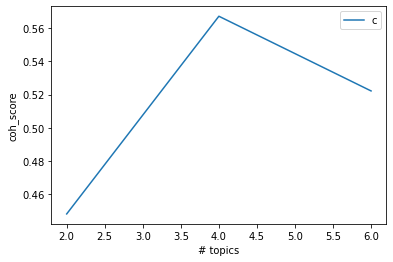

In [15]:
# Ploting of coherence value
limit=7;start=2;step=2;
x=range(start,limit,step)
plt.plot(x,coh_val)
plt.xlabel('# topics')
plt.ylabel('coh_score')
plt.legend(("coh_val"),loc='best')
plt.show()

In [16]:
# Given this set only has 17 negative reviews, we dont want too many topics. Tried 4 here. looks like 1 and 3 are about service, and 2 and 4 about food being cold
lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary,num_topics=4, random_state=420, chunksize = 1000, passes =15)
lda_model.print_topics()

[(0,
  '0.025*"burger" + 0.016*"outside" + 0.011*"owner" + 0.011*"definitely" + 0.011*"drink" + 0.011*"bad" + 0.011*"fry" + 0.011*"attitude" + 0.011*"upon" + 0.011*"burgers"'),
 (1,
  '0.042*"burger" + 0.015*"fry" + 0.015*"mushroom" + 0.015*"patty" + 0.012*"cold" + 0.012*"toppings" + 0.012*"tell" + 0.012*"portobello" + 0.012*"surprise" + 0.010*"first"'),
 (2,
  '0.024*"napkins" + 0.017*"small" + 0.017*"sticky" + 0.009*"hamburger" + 0.009*"back" + 0.009*"ask" + 0.009*"rude" + 0.009*"price" + 0.009*"behind" + 0.009*"best"'),
 (3,
  '0.032*"burger" + 0.017*"get" + 0.017*"burgers" + 0.017*"like" + 0.017*"taste" + 0.012*"back" + 0.012*"freeze" + 0.012*"price" + 0.012*"cold" + 0.012*"inside"')]

In [17]:
# Even though combined cohrence score is lower for 6 topics but the explainability of topics is important. There is always an option to pick the top ones. Sometimes it may turn out to be better because it brings the separation out in clusters
lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary,num_topics=6, random_state=420, chunksize = 1000, passes =15)
lda_model.print_topics()

[(0,
  '0.028*"burger" + 0.019*"burgers" + 0.019*"outside" + 0.010*"owner" + 0.010*"bad" + 0.010*"mediocre" + 0.010*"attitude" + 0.010*"drink" + 0.010*"prepare" + 0.010*"bring"'),
 (1,
  '0.036*"burger" + 0.026*"fry" + 0.016*"patty" + 0.016*"approach" + 0.016*"turkey" + 0.016*"beef" + 0.011*"tell" + 0.011*"owner" + 0.011*"hard" + 0.011*"check"'),
 (2,
  '0.024*"napkins" + 0.017*"burger" + 0.017*"review" + 0.017*"small" + 0.017*"price" + 0.017*"sticky" + 0.009*"bother" + 0.009*"around" + 0.009*"mediocre" + 0.009*"fly"'),
 (3,
  '0.023*"get" + 0.023*"back" + 0.023*"burger" + 0.012*"toppings" + 0.012*"like" + 0.012*"ask" + 0.012*"give" + 0.012*"work" + 0.012*"people" + 0.012*"orient"'),
 (4,
  '0.046*"burger" + 0.026*"cold" + 0.026*"mushroom" + 0.017*"like" + 0.017*"dry" + 0.017*"portobello" + 0.017*"toppings" + 0.017*"surprise" + 0.013*"freeze" + 0.013*"first"'),
 (5,
  '0.011*"cold" + 0.011*"look" + 0.011*"counter" + 0.011*"hamburger" + 0.011*"taste" + 0.011*"behind" + 0.011*"outside" +

In [18]:
# First 3 topics are very well separated and look good 
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

# feed the LDA model into the pyLDAvis instance
lda_viz = gensimvis.prepare(lda_model, doc_term_matrix, dictionary)
lda_viz

/Applications/anaconda3/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(
/Applications/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Applications/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Applications/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Applications/anaconda3/lib/python3.9/site-packages/pa

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.186509 -0.009112       1        1  33.371517
1     -0.057923 -0.130809       2        1  26.109870
2     -0.042524  0.100223       3        1  13.754297
0     -0.056208  0.004445       4        1  10.327638
5     -0.039758  0.034531       5        1   9.209450
3      0.009903  0.000722       6        1   7.227228, topic_info=         Term      Freq     Total Category  logprob  loglift
25       back  3.000000  3.000000  Default  30.0000  30.0000
10        get  4.000000  4.000000  Default  29.0000  29.0000
162   napkins  2.000000  2.000000  Default  28.0000  28.0000
58   mushroom  5.000000  5.000000  Default  27.0000  27.0000
63      price  4.000000  4.000000  Default  26.0000  26.0000
..        ...       ...       ...      ...      ...      ...
35   toppings  0.496998  4.062453   Topic6  -4.3836   0.5264
13       like  0.496927  4.783724   Topic6  -4.3837   0.3628
56       menu  0.496778  3.256722   Topic6  -4.3840   0.7470
21      taste  0.496709  3.026288   Topic6  -4.3842   0.8202
63      price  0.496679  4.474595   Topic6  -4.3842   0.4291

[295 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
39        1  0.947969      act
83        3  0.854717      add
141       3  0.854436      air
204       2  0.766888  already
84        2  0.419926     also
...     ...       ...      ...
123       4  0.914531   window
36        2  0.578084     work
79        1  0.706525    worse
79        2  0.353262    worse
294       4  0.914623     yell

[274 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 2, 3, 1, 6, 4])

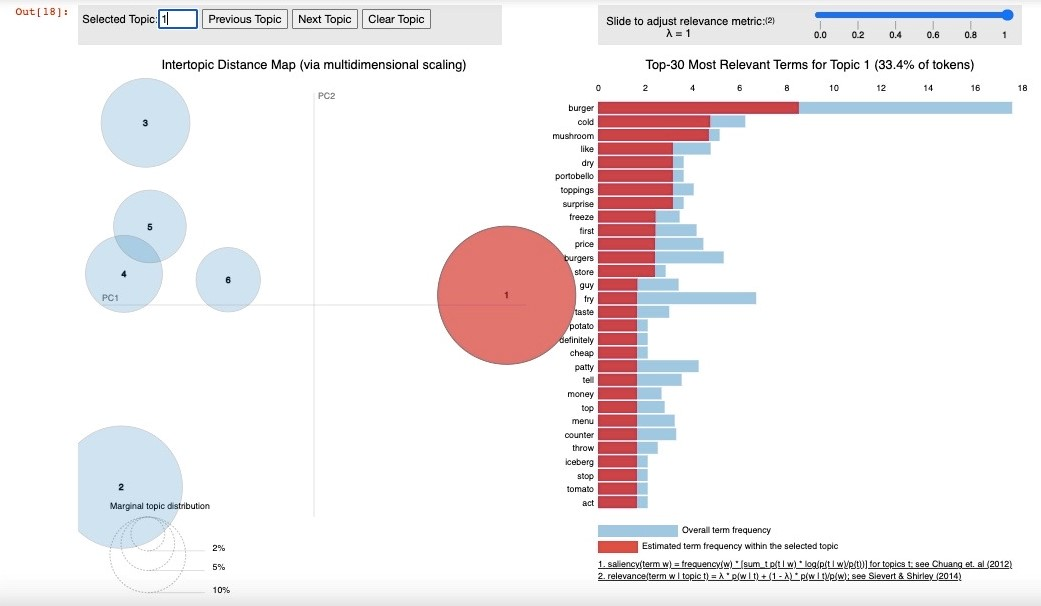

In [19]:
# Combining all the information back into a single dataframe
all_topics = lda_model.get_document_topics(doc_term_matrix, minimum_probability=0.0)
all_topics_csr = gensim.matutils.corpus2csc(all_topics)
all_topics_numpy = all_topics_csr.T.toarray()
all_topics_df = pd.DataFrame(all_topics_numpy)

topic = all_topics_df.idxmax(axis=1)
all_topics_df_1 = all_topics_df.reset_index()
topic_1 = topic.reset_index()
final = pd.merge(all_topics_df_1,topic_1,on='index')
final.columns = ['doc_no','t_1','t_2','t_3','t_4','t_5','t_6','dominant_topic']
final_df_2 = pd.concat([final,data],axis=1)
final_df_2


# Format
df_dominant_topic = final_df_2.reset_index()
df_dominant_topic.columns = ['index','Document_No','t_1','t_2','t_3','t_4','t_5','t_6','dominant_topic', 'Sentiment_score', 'Text', 'Sentiment','Date']
df_dominant_topic_1 = df_dominant_topic[['Document_No','dominant_topic', 'Sentiment_score', 'Text', 'Sentiment','Date']]
df_dominant_topic_1 = df_dominant_topic_1[['Document_No', 'Text', 'Sentiment', 'Sentiment_score', 'dominant_topic','Date']]
df_dominant_topic_1


,Document_No,Text,Sentiment,Sentiment_score,dominant_topic,Date
0,0,First time going here since it's changed owner...,Negative,-0.007333,4,20-Dec
1,1,We got the wrong food and then get gave us bac...,Negative,-0.044444,3,20-Dec
2,2,I stopped by at the Clinton location in Nov-20...,Negative,-0.137126,4,20-Dec
3,3,LOUSIEST BURGER AND SERVICE.... I wish I can g...,Negative,-0.140394,4,20-Nov
4,4,over priced mediocre burger..waste of money. c...,Negative,-0.041667,2,20-Nov
5,5,"My boyfriend and I went in, places our order (...",Negative,-0.344444,0,20-Sep
6,6,Just ordered dinner via door dash. Sweet potat...,Negative,-0.034896,4,20-Jul
7,7,I'm not sure why this place has such good revi...,Negative,-0.069265,2,20-Feb
8,8,"went there to try the burgers,,,,,asked for me...",Negative,-0.100000,0,19-Nov
9,9,Went for the first time this past Friday and w...,Negative,-0.125303,1,19-Oct


In [20]:
sent_topics_df = pd.DataFrame()

# Get the topic keywords of the dominant topic
for i, row in enumerate(lda_model[doc_term_matrix]):
    row = sorted(row, key=lambda x: (x[1]), reverse=True)
    # Get the Dominant topic, Perc Contribution and Keywords for each document
    for j, (topic_num, prop_topic) in enumerate(row):
        if j == 0:  # => dominant topic
            wp = lda_model.show_topic(topic_num)
            topic_keywords = ", ".join([word for word, prop in wp])
            sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), topic_keywords]), ignore_index=True)
        else:
            break
sent_topics_df.columns = ['Dominant_Topic', 'Topic_Keywords']
sent_topics_df = sent_topics_df.reset_index()
sent_topics_df.columns = ['Document_No','Dominant_Topic', 'Topic_Keywords']
#sent_topics_df

In [21]:
# Add the dominant topic details to the dataframe
sent_topics_df_neg = pd.concat([df_dominant_topic_1,sent_topics_df], axis=1)
sent_topics_df_neg = sent_topics_df_neg[['Document_No','Text','Sentiment','Sentiment_score','Dominant_Topic','Topic_Keywords','Date']]
sent_topics_df_neg


,Document_No,Document_No,Text,Sentiment,Sentiment_score,Dominant_Topic,Topic_Keywords,Date
0,0,0,First time going here since it's changed owner...,Negative,-0.007333,4.0,"burger, cold, mushroom, like, dry, portobello,...",20-Dec
1,1,1,We got the wrong food and then get gave us bac...,Negative,-0.044444,3.0,"get, back, burger, toppings, like, ask, give, ...",20-Dec
2,2,2,I stopped by at the Clinton location in Nov-20...,Negative,-0.137126,4.0,"burger, cold, mushroom, like, dry, portobello,...",20-Dec
3,3,3,LOUSIEST BURGER AND SERVICE.... I wish I can g...,Negative,-0.140394,4.0,"burger, cold, mushroom, like, dry, portobello,...",20-Nov
4,4,4,over priced mediocre burger..waste of money. c...,Negative,-0.041667,2.0,"napkins, burger, review, small, price, sticky,...",20-Nov
5,5,5,"My boyfriend and I went in, places our order (...",Negative,-0.344444,0.0,"burger, burgers, outside, owner, bad, mediocre...",20-Sep
6,6,6,Just ordered dinner via door dash. Sweet potat...,Negative,-0.034896,4.0,"burger, cold, mushroom, like, dry, portobello,...",20-Jul
7,7,7,I'm not sure why this place has such good revi...,Negative,-0.069265,2.0,"napkins, burger, review, small, price, sticky,...",20-Feb
8,8,8,"went there to try the burgers,,,,,asked for me...",Negative,-0.100000,0.0,"burger, burgers, outside, owner, bad, mediocre...",19-Nov
9,9,9,Went for the first time this past Friday and w...,Negative,-0.125303,1.0,"burger, fry, patty, approach, turkey, beef, te...",19-Oct


## Topic Modeling on Positive Reviews

In [22]:
# Filtering of positive reviews. Total of 119 as shown in the results of info function
data = data2[data2['Sentiment_Pred_tb']=='Positive']
data.reset_index(drop=True, inplace=True)
data.info()
data.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119 entries, 0 to 118
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Review             119 non-null    float64
 1   Feedback_text      119 non-null    object 
 2   Sentiment_Pred_tb  119 non-null    object 
 3   Date               119 non-null    object 
dtypes: float64(1), object(3)
memory usage: 3.8+ KB


,Review,Feedback_text,Sentiment_Pred_tb,Date
0,0.174444,"Burger Co, in a word, rocks. I read some of th...",Positive,21-Aug
1,0.375000,Spicy burger is amazing. Huge burgers cooked t...,Positive,21-Jul
2,0.360000,Don't be fooled by the lack of atmosphere. The...,Positive,21-Jul
3,0.421429,I happened to stumble upon this place last yea...,Positive,21-Jul
4,0.080000,"Big, high quality burgers with all the fixin's...",Positive,21-Jun
5,0.350000,Reasonable prices and located in a cute town,Positive,21-Jun
6,0.300000,Was told there was no chicken patty even thoug...,Positive,21-Jun
7,0.250694,We visited the Burger Co. for the first time a...,Positive,21-Jun
8,0.550000,Wish I found this place sooner. Great burgers ...,Positive,21-Jun
9,0.379167,"I come here often, and the food is consistentl...",Positive,21-Apr


In [23]:
# Cleanup of reviews: removal of email addresses and any links
# Stemming and lemmatization of words to standarized the words
# Finally creating a corpus of selected words
corpus = []
df_list = list(data['Feedback_text'])

for i in range(len(df_list)):
    review = df_list[i]
    review = re.sub('\S*@\S*\s', " ", review) # remove any emails
    review = re.sub('http\S*\s', " ", review) # remove any links
    
    review = re.sub(r'[^\w\s]'," ", review) # removes all characters except letters numbers whitespace and underscore 
    
    review = review.lower()

    review_words = review.split()
    
    # Remove stopwords
    stpwords = set(stopwords.words('english'))
    
    review_words = [word for word in review_words if not word in stpwords]

    # Stemming and Lemmatize the words
    ps = PorterStemmer()
    lm = WordNetLemmatizer()
    
    review = [lm.lemmatize(word,"v") for word in review_words] 
    
    # Bringing the stemming back as we are working with a lot more words here and further standization will help
    # The results only show marginal imporovement post going through the steps hence keeping it commented
    
    # review = [ps.stem(word) for word in review]

   # Adding new stopwords to ensure not so relevant words are filtered out. Also removing good as it can cause confusion
    new_stopwords = ["would", "today", "via", "local","food", "table", "order", "time", "place", "come","try","eat"]

    review = [word for word in review if not word in new_stopwords]
    
    # Joining the words
    review = ' '.join(review)
    # Removing up to two letter words if not filtered otherwise
    review = ' '.join([i for i in review.split() if len(i) >= 3])

    # Creating a corpus
    corpus.append(review)

<>:9: DeprecationWarning: invalid escape sequence \S
<>:10: DeprecationWarning: invalid escape sequence \S
<>:9: DeprecationWarning: invalid escape sequence \S
<>:10: DeprecationWarning: invalid escape sequence \S
/var/folders/wb/brjrts2j4p70vyg8c4q4qlz00000gq/T/ipykernel_16942/1140811092.py:9: DeprecationWarning: invalid escape sequence \S
  review = re.sub('\S*@\S*\s', " ", review) # remove any emails
/var/folders/wb/brjrts2j4p70vyg8c4q4qlz00000gq/T/ipykernel_16942/1140811092.py:10: DeprecationWarning: invalid escape sequence \S
  review = re.sub('http\S*\s', " ", review) # remove any links


In [24]:
# Put the corpus in a data frame
df = pd.DataFrame(corpus, columns=['dep_var'])
df.head(10)

,dep_var
0,burger word rock read less complimentary revie...
1,spicy burger amaze huge burgers cook potato br...
2,fool lack atmosphere interior dirty look like ...
3,happen stumble upon last year remember best bu...
4,big high quality burgers fixin accompaniments ...
5,reasonable price locate cute town
6,tell chicken patty even though menu state carr...
7,visit burger first expect bite visit location ...
8,wish find sooner great burgers cajun fry worth...
9,often consistently good burgers level five guy...


In [25]:
# Create a dictionary to be able to perform bag of words analysis
tokens = df['dep_var'].apply(lambda x:x.split())
dictionary = corpora.Dictionary(pd.Series(tokens))
print(dictionary)

Dictionary(900 unique tokens: ['anything', 'bang', 'burger', 'business', 'cannot']...)


In [30]:
# Use doc2bow function to get a bag of words and create document term matrix
doc_term_matrix = [dictionary.doc2bow(rev) for rev in tokens]
LDA = gensim.models.ldamodel.LdaModel
print(doc_term_matrix)
# Lot more terms compared to terms in negative reviews as expected

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1)], [(2, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1)], [(2, 1), (34, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 2), (54, 1), (55, 1), (56, 1), (57, 1), (58, 2), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 2), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 1), (75, 2)], [(2, 2), (50, 1), (56, 1), (67, 1), (76, 1), (77, 1), (78, 1), (79, 1), (80, 1), (81, 1), (82, 1), (83, 1), (84, 1), (85, 1), (86, 1), (87, 1), (88, 1), (89, 1)], [(34, 1), (60, 1), (90, 1), (91, 1), (92, 1), (93, 1), (94, 1)], [(83, 1), (84, 1), (95, 1), (96, 1), (97, 1)], [(2, 1), (8, 1), (3

In [31]:
# Coherence score function has already been defined above. Going for 4 options: 2, 4, 6 and 8
model_lst, coh_val = coherence_Score(dictionary, doc_term_matrix, tokens, start=2, limit=10, step=2)
model_lst, coh_val

2
4
6
8


([<gensim.models.ldamodel.LdaModel at 0x7f9ddf004550>,
 [0.35934364975184163,
  0.319146348497804,
  0.31390327492683645,
  0.3050830458915707])

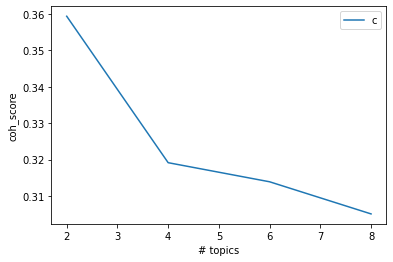

In [32]:
# Plotting the scores. Even though the diagram shows a big trend but otherwise the scores are close to each other
limit=10;start=2;step=2;
x=range(start,limit,step)
plt.plot(x,coh_val)
plt.xlabel('# topics')
plt.ylabel('coh_score')
plt.legend(("coh_val"),loc='best')
plt.show()

In [33]:
# Terms selected by the LDA model for 2 topics
lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary,num_topics=2, random_state=420, chunksize = 1000, passes =15)
lda_model.print_topics()

[(0,
  '0.027*"burger" + 0.017*"good" + 0.016*"great" + 0.012*"service" + 0.011*"fry" + 0.011*"well" + 0.009*"burgers" + 0.008*"clinton" + 0.007*"nice" + 0.007*"johnny"'),
 (1,
  '0.027*"burger" + 0.023*"burgers" + 0.020*"fry" + 0.015*"good" + 0.013*"great" + 0.009*"get" + 0.009*"like" + 0.009*"cook" + 0.008*"back" + 0.007*"fresh"')]

In [34]:
# Terms selected by the LDA model for 6 topics. This looks better in terms of explainability
lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary,num_topics=6, random_state=420, chunksize = 1000, passes =15)
lda_model.print_topics()

[(0,
  '0.038*"burger" + 0.017*"fry" + 0.016*"well" + 0.016*"burgers" + 0.014*"good" + 0.011*"definitely" + 0.010*"tasty" + 0.008*"better" + 0.008*"best" + 0.008*"sandwich"'),
 (1,
  '0.026*"burgers" + 0.023*"burger" + 0.015*"fry" + 0.014*"great" + 0.013*"best" + 0.012*"service" + 0.011*"like" + 0.011*"fresh" + 0.010*"good" + 0.009*"clinton"'),
 (2,
  '0.034*"good" + 0.028*"burger" + 0.017*"great" + 0.013*"fry" + 0.013*"price" + 0.012*"service" + 0.011*"also" + 0.011*"nice" + 0.009*"get" + 0.008*"burgers"'),
 (3,
  '0.036*"burger" + 0.021*"burgers" + 0.020*"fry" + 0.014*"good" + 0.012*"great" + 0.012*"like" + 0.011*"nice" + 0.011*"bacon" + 0.011*"rare" + 0.010*"delicious"'),
 (4,
  '0.033*"burgers" + 0.018*"great" + 0.017*"fry" + 0.016*"cook" + 0.012*"price" + 0.010*"next" + 0.010*"size" + 0.010*"home" + 0.009*"back" + 0.008*"good"'),
 (5,
  '0.024*"burger" + 0.019*"fry" + 0.017*"great" + 0.011*"burgers" + 0.010*"good" + 0.010*"hear" + 0.009*"like" + 0.009*"johnny" + 0.009*"cook" + 0.0

In [ ]:
# First 4 topics are well separated on visualization and look great 
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

# Feed the LDA model into the pyLDAvis instance
lda_viz = gensimvis.prepare(lda_model, doc_term_matrix, dictionary)
lda_viz

/Applications/anaconda3/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.005922  0.101960       1        1  24.341309
1      0.042583 -0.075879       2        1  21.946959
2      0.086476  0.036672       3        1  21.536653
5     -0.131776  0.004451       4        1  16.225300
0     -0.002647 -0.002431       5        1   9.096044
4     -0.000559 -0.064772       6        1   6.853735, topic_info=           Term       Freq      Total Category  logprob  loglift
34      burgers  50.000000  50.000000  Default  30.0000  30.0000
168        well  12.000000  12.000000  Default  29.0000  29.0000
2        burger  77.000000  77.000000  Default  28.0000  28.0000
35         cook  19.000000  19.000000  Default  27.0000  27.0000
99      chicken   8.000000   8.000000  Default  26.0000  26.0000
..          ...        ...        ...      ...      ...      ...
124        good   1.482523  45.382622   Topic6  -4.8607  -0.7410
176  definitely   0.993442  15.691992   Topic6  -5.2611  -0.0794
2        burger   1.247455  77.445817   Topic6  -5.0334  -1.4481
188   recommend   0.672595   9.922250   Topic6  -5.6511  -0.0110
141       shake   0.672470   9.186780   Topic6  -5.6513   0.0658

[406 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
362       6  0.766687            able
90        6  0.766759  accompaniments
540       2  0.763280             add
540       3  0.254427             add
402       6  0.766690      affordable
...     ...       ...             ...
218       2  0.471914            work
218       3  0.157305            work
89        3  0.646059            year
311       3  0.865920           years
351       2  0.955400           young

[638 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 3, 6, 1, 5])

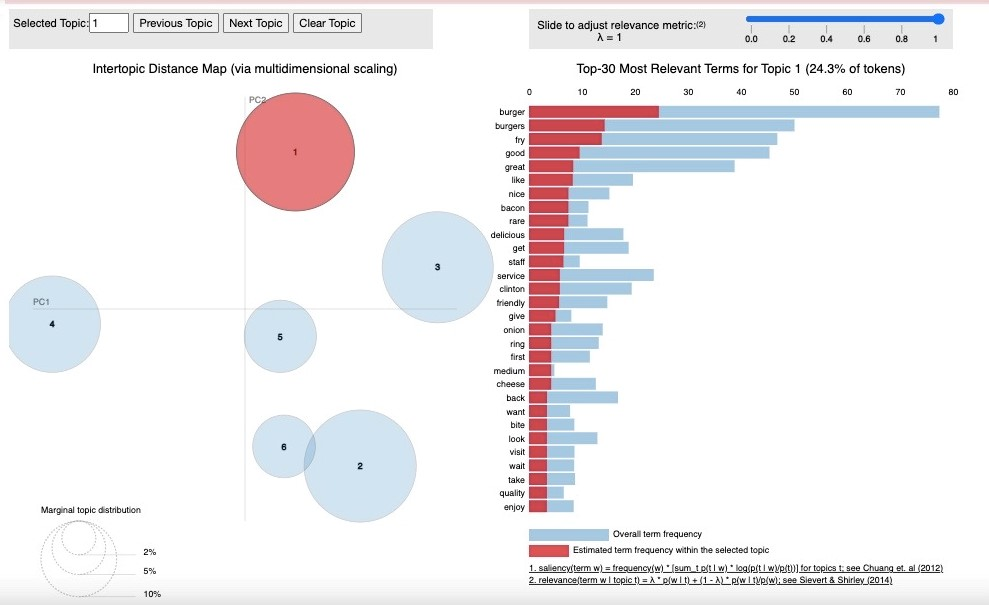

In [36]:
# Combining all the information back into a single dataframe
all_topics = lda_model.get_document_topics(doc_term_matrix, minimum_probability=0.0)
all_topics_csr = gensim.matutils.corpus2csc(all_topics)
all_topics_numpy = all_topics_csr.T.toarray()
all_topics_df = pd.DataFrame(all_topics_numpy)

topic = all_topics_df.idxmax(axis=1)
all_topics_df_1 = all_topics_df.reset_index()
topic_1 = topic.reset_index()
final = pd.merge(all_topics_df_1,topic_1,on='index')
final.columns = ['doc_no','t_1','t_2','t_3','t_4','t_5','t_6','dominant_topic']
final_df_2 = pd.concat([final,data],axis=1)
final_df_2


# Format
df_dominant_topic = final_df_2.reset_index()
df_dominant_topic.columns = ['index','Document_No','t_1','t_2','t_3','t_4','t_5','t_6','dominant_topic', 'Sentiment_score', 'Text', 'Sentiment','Date']
df_dominant_topic_1 = df_dominant_topic[['Document_No','dominant_topic', 'Sentiment_score', 'Text', 'Sentiment','Date']]
df_dominant_topic_1 = df_dominant_topic_1[['Document_No', 'Text', 'Sentiment', 'Sentiment_score', 'dominant_topic','Date']]
df_dominant_topic_1

,Document_No,Text,Sentiment,Sentiment_score,dominant_topic,Date
0,0,"Burger Co, in a word, rocks. I read some of th...",Positive,0.174444,5,21-Aug
1,1,Spicy burger is amazing. Huge burgers cooked t...,Positive,0.375000,4,21-Jul
2,2,Don't be fooled by the lack of atmosphere. The...,Positive,0.360000,3,21-Jul
3,3,I happened to stumble upon this place last yea...,Positive,0.421429,2,21-Jul
4,4,"Big, high quality burgers with all the fixin's...",Positive,0.080000,4,21-Jun
...,...,...,...,...,...,...
114,114,"Meh. It was just ok. I've had better hot dogs,...",Positive,0.081250,0,17-Mar
115,115,My wife and I stopped in the other night and h...,Positive,0.258333,2,17-Feb
116,116,Someone told me that the other place closed an...,Positive,0.211562,2,17-Feb
117,117,Husband picked up the eggplant parm sub and me...,Positive,0.387500,0,16-Dec


In [37]:
sent_topics_df = pd.DataFrame()

# Get the topic keywords of the dominant topic
for i, row in enumerate(lda_model[doc_term_matrix]):
    row = sorted(row, key=lambda x: (x[1]), reverse=True)
    # Get the Dominant topic, Perc Contribution and Keywords for each document
    for j, (topic_num, prop_topic) in enumerate(row):
        if j == 0:  # => dominant topic
            wp = lda_model.show_topic(topic_num)
            topic_keywords = ", ".join([word for word, prop in wp])
            sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), topic_keywords]), ignore_index=True)
        else:
            break
sent_topics_df.columns = ['Dominant_Topic', 'Topic_Keywords']
sent_topics_df = sent_topics_df.reset_index()
sent_topics_df.columns = ['Document_No','Dominant_Topic', 'Topic_Keywords']
#sent_topics_df

In [38]:
# Add the dominant topic details to the dataframe
sent_topics_df_pos = pd.concat([df_dominant_topic_1,sent_topics_df], axis=1)
sent_topics_df_pos = sent_topics_df_pos[['Document_No','Text','Sentiment','Sentiment_score','Dominant_Topic','Topic_Keywords','Date']]
sent_topics_df_pos

,Document_No,Document_No,Text,Sentiment,Sentiment_score,Dominant_Topic,Topic_Keywords,Date
0,0,0,"Burger Co, in a word, rocks. I read some of th...",Positive,0.174444,5.0,"burger, fry, great, burgers, good, hear, like,...",21-Aug
1,1,1,Spicy burger is amazing. Huge burgers cooked t...,Positive,0.375000,4.0,"burgers, great, fry, cook, price, next, size, ...",21-Jul
2,2,2,Don't be fooled by the lack of atmosphere. The...,Positive,0.360000,3.0,"burger, burgers, fry, good, great, like, nice,...",21-Jul
3,3,3,I happened to stumble upon this place last yea...,Positive,0.421429,2.0,"good, burger, great, fry, price, service, also...",21-Jul
4,4,4,"Big, high quality burgers with all the fixin's...",Positive,0.080000,4.0,"burgers, great, fry, cook, price, next, size, ...",21-Jun
...,...,...,...,...,...,...,...,...
114,114,114,"Meh. It was just ok. I've had better hot dogs,...",Positive,0.081250,0.0,"burger, fry, well, burgers, good, definitely, ...",17-Mar
115,115,115,My wife and I stopped in the other night and h...,Positive,0.258333,2.0,"good, burger, great, fry, price, service, also...",17-Feb
116,116,116,Someone told me that the other place closed an...,Positive,0.211562,2.0,"good, burger, great, fry, price, service, also...",17-Feb
117,117,117,Husband picked up the eggplant parm sub and me...,Positive,0.387500,0.0,"burger, fry, well, burgers, good, definitely, ...",16-Dec


## Merge Pos and Neg dataframe

In [39]:
sent_topics_df_final = sent_topics_df_pos.append(sent_topics_df_neg, ignore_index=True)
sent_topics_df_final = sent_topics_df_final[['Text','Sentiment','Sentiment_score','Dominant_Topic','Topic_Keywords','Date']]
sent_topics_df_final = sent_topics_df_final.reset_index()
sent_topics_df_final

,index,Text,Sentiment,Sentiment_score,Dominant_Topic,Topic_Keywords,Date
0,0,"Burger Co, in a word, rocks. I read some of th...",Positive,0.174444,5.0,"burger, fry, great, burgers, good, hear, like,...",21-Aug
1,1,Spicy burger is amazing. Huge burgers cooked t...,Positive,0.375000,4.0,"burgers, great, fry, cook, price, next, size, ...",21-Jul
2,2,Don't be fooled by the lack of atmosphere. The...,Positive,0.360000,3.0,"burger, burgers, fry, good, great, like, nice,...",21-Jul
3,3,I happened to stumble upon this place last yea...,Positive,0.421429,2.0,"good, burger, great, fry, price, service, also...",21-Jul
4,4,"Big, high quality burgers with all the fixin's...",Positive,0.080000,4.0,"burgers, great, fry, cook, price, next, size, ...",21-Jun
...,...,...,...,...,...,...,...
131,131,This place changed hands for the 3rd time. I h...,Negative,-0.095833,3.0,"get, back, burger, toppings, like, ask, give, ...",18-Dec
132,132,"Wife ordered a black bean burger, which are de...",Negative,-0.013333,4.0,"burger, cold, mushroom, like, dry, portobello,...",18-Jun
133,133,"Ordered a hamburger and fries, was meh. The ow...",Negative,-0.255556,1.0,"burger, fry, patty, approach, turkey, beef, te...",17-Jul
134,134,"Food isn't bad. However, the place is not kid ...",Negative,-0.041667,0.0,"burger, burgers, outside, owner, bad, mediocre...",17-May


In [40]:
# Save the final data to a csv
sent_topics_df_final.to_csv('/Users/vatsalgarg/Downloads/InsightsHub/sent_topics_df_final.csv')